In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import heapq

In [2]:
# 数据导入
train_data = pd.read_csv('train_dataset.csv')
test_data = pd.read_csv('test_dataset.csv')

X_train = train_data.drop(['Overpotential(mV)'], axis=1).values
y_train = train_data['Overpotential(mV)'].values

X_test = test_data.drop(['Overpotential(mV)'], axis=1).values
y_test = test_data['Overpotential(mV)'].values

In [ ]:
# #创建训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 15/77, random_state=42)

# # 将特征数据和标签数据合并（横向拼接）
# train_data = pd.concat([pd.DataFrame(X_train), pd.Series(y_train, name='target')], axis=1)
# test_data = pd.concat([pd.DataFrame(X_test), pd.Series(y_test, name='target')], axis=1)

# # 保存到CSV文件（默认保存到当前工作目录）
# train_data.to_csv('train_dataset.csv', index=False)
# test_data.to_csv('test_dataset.csv', index=False)

In [4]:
#定义网格参数
# n_estimators：森林中树的数量。默认是100
# max_depth：树的最大深度。如果未设置，则节点会扩展直到所有叶子都是纯的，或者直到所有叶子包含的样本少于 min_samples_split
# min_samples_split：分割内部节点所需的最小样本数
# min_samples_leaf：叶节点所需的最小样本数
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 50],
    'min_samples_split': [2, 3 , 4],
    'min_samples_leaf': [1, 3, 5]
}

In [5]:
# 创建RandomForestRegressor模型
GBM = GradientBoostingRegressor(random_state=42)

# 创建网格搜索对象
grid_search = GridSearchCV(estimator=GBM, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 训练模型
grid_search.fit(X_train, y_train)

# 查找最优参数
best_params = grid_search.best_params_
# print(best_params)

# 使用最优参数重新训练模型
GBM_best = GradientBoostingRegressor(**best_params, random_state=42)
GBM_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=None, min_samples_leaf=5, n_estimators=200,
                          random_state=42)

In [6]:
#训练集上数据的误差
y_train_pred = GBM_best.predict(X_train)

# 在测试集上评估模型
y_test_pred = GBM_best.predict(X_test)

# 计算训练集上的误差
mse_train = mean_squared_error(y_train, y_train_pred)

# 计算测试集上的误差
mse_test = mean_squared_error(y_test, y_test_pred)

# 输出结果
print("训练集上的误差（Overpotential(mV)）：")
print(f"MSE: {mse_train}")

print("\n测试集上的误差（Overpotential(mV)）：")
print(f"MSE: {mse_test}")

训练集上的误差（Overpotential(mV)）：
MSE: 621.6281512605655

测试集上的误差（Overpotential(mV)）：
MSE: 3335.438478676329


In [6]:
plt.rcParams.update({
    # 英文/数字：Times New Roman
    "font.family": ["Times New Roman"],

    # 字体大小：小五号（约 9pt）
    "font.size": 12,          # 全局字体大小
    "axes.titlesize": 14,     # 标题
    "axes.labelsize": 14,     # 坐标轴标签
    "xtick.labelsize": 12,    # X轴刻度
    "ytick.labelsize": 12,    # Y轴刻度
    "legend.fontsize": 14,    # 图例
})

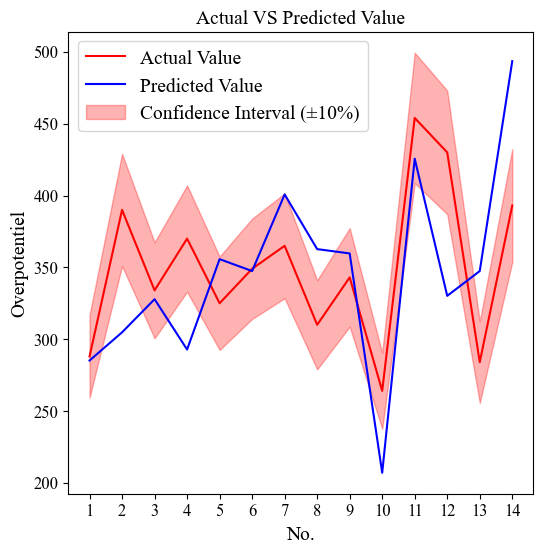

In [7]:
#测试集上模型准确度可视化
#添加置信区间
lower_bound = y_test * 0.9  # 下限（实际值的90%）
upper_bound = y_test * 1.1  # 上限（实际值的110%）
plt.figure(figsize=(6,6))
plt.plot(y_test ,color='red', label = 'Actual Value')
plt.plot(y_test_pred, color='blue', label='Predicted Value')
plt.fill_between(range(len(y_test)), lower_bound, upper_bound, color='red', alpha=0.3, label='Confidence Interval (±10%)')
# 设置 x 轴的刻度和标签
x_ticks = np.arange(0, len(y_test))  # 原始刻度位置（0-14）
x_tick_labels = np.arange(1, len(y_test) + 1)  # 新的标签（1-15）
plt.xticks(x_ticks, x_tick_labels)  # 设置刻度位置和标签

plt.title('Actual VS Predicted Value')
plt.xlabel('No.')
plt.ylabel('Overpotentiel')
plt.legend()
plt.show()

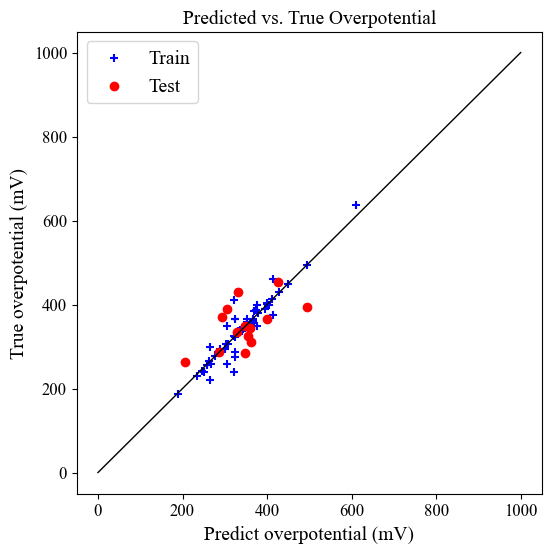

In [8]:
# 画出真实值与预测值的对比图
plt.figure(figsize=(6,6))
plt.scatter(y_train_pred, y_train, color='blue', label='Train', marker='+')
plt.scatter(y_test_pred, y_test, color='red', label='Test', marker='o')
plt.plot([0, 1000], [0, 1000], color='black', linestyle='-', linewidth=1)  # y=x 参考线

plt.xlabel("Predict overpotential (mV)")
plt.ylabel("True overpotential (mV)")
plt.legend()
plt.title("Predicted vs. True Overpotential")
plt.show()

In [9]:
real_test_data = pd.read_excel('real_test_data.xlsx')
real_test_data.to_csv('real_test_data.csv',index=False)


In [10]:
result = GBM_best.predict(real_test_data.values)
print(result)

[346.81724735 219.61241701 353.59649991]


In [8]:
#调用随机生成的数据进行预测
random_dataset = pd.read_csv('random_features.csv')
y_random_pred = GBM_best.predict(random_dataset)

# 将随机生成的数据与预测结果合并
y_random_pred_df = pd.DataFrame(y_random_pred, columns=['Overpotential(mV)'])
random_dataset_with_predictions = pd.concat([random_dataset, y_random_pred_df], axis=1)

# 将随机生成的数据及其预测结果保存到CSV文件
random_dataset_with_predictions.to_csv('random_dataset_with_predictions.csv', index=False)
print("随机数据和预测结果已保存到 random_dataset_with_predictions.csv 文件中。")

# 寻找最低的10个过电位及其对应的x值
top_10 = y_random_pred_df.nsmallest(10, 'Overpotential(mV)')

# 合并最低过电位数据与对应的输入特征
top_10_indices = top_10.index
top_10_full_data = pd.concat([random_dataset.iloc[top_10_indices].reset_index(drop=True), top_10.reset_index(drop=True)], axis=1)

# 将最低10个过电位的完整数据保存到CSV文件
top_10_full_data.to_csv('top_10_lowest_overpotential.csv', index=False)
print("最低10个过电位及其对应数据已保存到 top_10_lowest_overpotential.csv 文件中。")

随机数据和预测结果已保存到 random_dataset_with_predictions.csv 文件中。
最低10个过电位及其对应数据已保存到 top_10_lowest_overpotential.csv 文件中。


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
